***

<font color='green'>

# Project Solution: Neural Network - Project 2
#### Filename: Autonomous_Vehicles_SVHN_single_grey1.h5 (http://ufldl.stanford.edu/housenumbers/)
#### File consists of data for street view images
#### Purpose: Build a digit classifier on the SVHN (Street View Housing Number) dataset
#### Learning Outcome: Importing h5 data, Data Pre-processing, Neural Network Image Classification
***
***
*Prepared by: Sauvik De*

*Date: March 15, 2021*
    
</font>

***

In [131]:
# Initialize the random number generator
import random
random.seed(1)

# Import necessary libraries
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# import tensorflow
import tensorflow as tf

#### Load h5 image datafile

In [2]:
# Read in image datafile
f = h5py.File('Autonomous_Vehicles_SVHN_single_grey1.h5', "r")

# List all groups
print(list(f.keys()))

['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']


In [3]:
# Read training, validation and test data in
X_train, X_val, X_test, y_train, y_val, y_test = np.array(f['X_train']), np.array(f['X_val']), np.array(f['X_test']), \
                                                    np.array(f['y_train']), np.array(f['y_val']), np.array(f['y_test'])

In [4]:
# Check out shapes of data read in
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((42000, 32, 32),
 (60000, 32, 32),
 (18000, 32, 32),
 (42000,),
 (60000,),
 (18000,))

#### Let's have a visual representation of the pixels (intensities) plotted

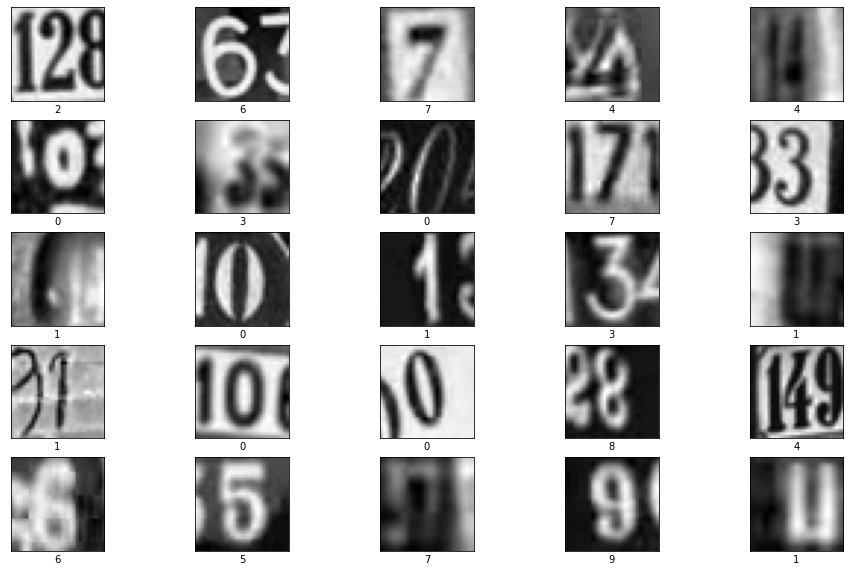

In [5]:
# Display first 25 images from training dataset
plt.figure(figsize=(16,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

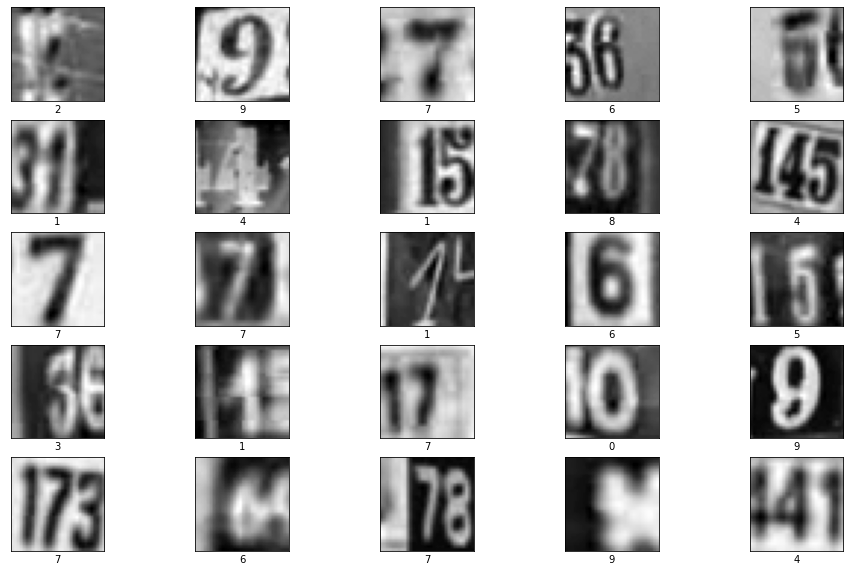

In [6]:
# Display 25 random images from validation dataset
import random
plt.figure(figsize=(16,10))
for i in range(25):
    j = random.randint(0,len(X_val)-1)
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[j], cmap=plt.cm.binary)
    plt.xlabel(y_val[j])
plt.show()

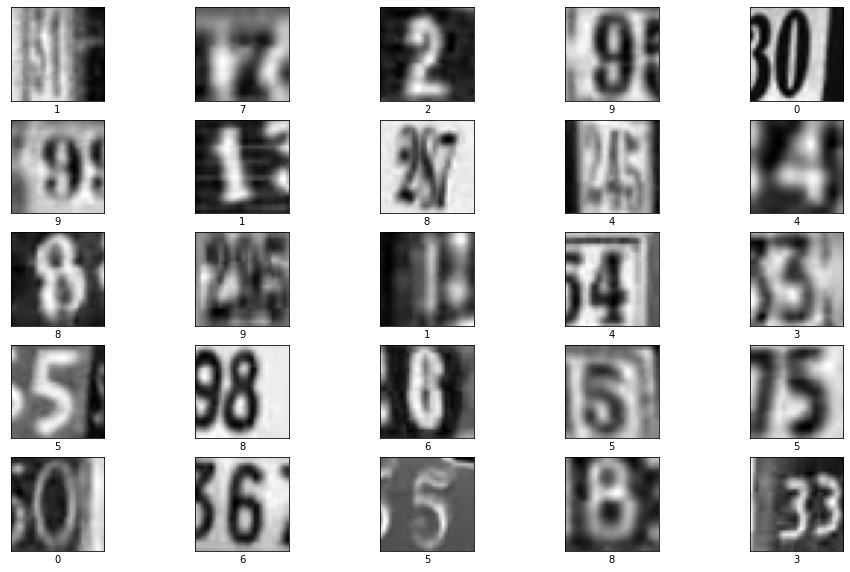

In [7]:
# Display first 25 images from test dataset
plt.figure(figsize=(16,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.xlabel(y_test[i])
plt.show()

#### Data pre-processing

In [5]:
print('X_train: (min, max):', (X_train.min(), X_train.max()))
print('X_val: (min, max):', (X_val.min(), X_val.max()))
print('X_test: (min, max):', (X_test.min(), X_test.max()))

X_train: (min, max): (0.0, 254.9745)
X_val: (min, max): (0.0, 254.9745)
X_test: (min, max): (0.0, 254.9745)


- Pixel values (image features) for all the images range between 0 and 254.9745.
- Pixel values of digital image should always be integer valued and must lie between 0 and 255
- It can be inferred that the feature data provided for this classification project doesn't seem to be raw data - but a processed data
- We scale features to range between 0 and 1 (Minmax scaling) - this will help network alogorithm to run more efficiently (for e.g.: learning weights using SGD algo)

In [6]:
# Scale feature set
X_train /= 254.9745
X_val /= 254.9745
X_test /= 254.9745

In [7]:
# Look at the unique values target variable takes
print('y_train unique values:', set(y_train))
print('y_val unique values:', set(y_val))
print('y_test unique values:', set(y_test))

y_train unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
y_val unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
y_test unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


- Response variable labels range between 0 and 9 each representing the prominent digit in an image.
- We can one-hot-encode it to make each digit a new class variable.
- We can further build Neural Network classifier on top of it with softmax activation function in the output layer - so network will calculate probability based numbers for each class per record to predict class membership.

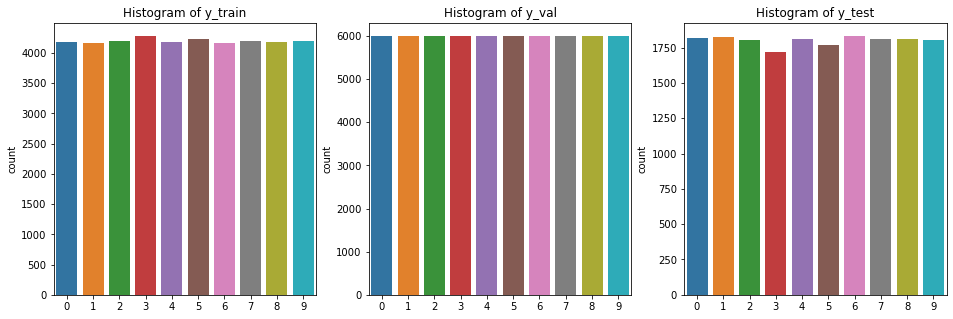

In [8]:
# Let's also take a look at frequency of occurrence of each of the digits in training, validation and test datasets
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
_ = sns.countplot(y_train, ax=ax[0]).set_title("Histogram of y_train")
_ = sns.countplot(y_val, ax=ax[1]).set_title("Histogram of y_val")
_ = sns.countplot(y_test, ax=ax[2]).set_title("Histogram of y_test")

- We have nearly equal representation from each of the digit categories for all of training, validation and test datasets
- We can infer that the data provided is well balanced

In [9]:
# One-Hot-Encode target variable
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val_encoded   = tf.keras.utils.to_categorical(y_val,   num_classes=10)
y_test_encoded  = tf.keras.utils.to_categorical(y_test,  num_classes=10)

#### We build a Neural Network based digit classifier

- Since input is a 32 by 32 image (gray scale), we flatten it to make an array of length 1024
- Since we are predicting digit in the paradigm of NN classification, and there are 10 digits (0 through 9), we will always have 10 output neurons, with softmax (preferably) activation function .. multiclass classification
 ***
- Let's start with simple NN having three hidden layers (HL) with 256, 128 and 64 neurons, Leaky ReLU as activation (alpha = 0.3) for each HL without any regularization (i.e., no dropout rates or no batch normalization)
- Since SVHN images are bit noisy in nature, we may want to use smaller batch sizes to make optimizer work better. Let's start with batch size 64 with Adam optimizer of learning rate 0.03

In [16]:
# Initialize Neural Network (Sequential) model
model = tf.keras.Sequential()

# Reshape the input of 32 x 32 image into 1d array with 1024 features
model.add(tf.keras.layers.Reshape(target_shape=(1024,), input_shape=(32,32,)))

# Add Layer 1 with 256 neurons and Leaky-ReLU activation function
model.add(tf.keras.layers.Dense(units=256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL1'))

# Add Layer 2 with 128 neurons and Leaky-ReLU activation function
model.add(tf.keras.layers.Dense(units=128, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL2'))

# Add Layer 3 with 64 neurons and Leaky-ReLU activation function
model.add(tf.keras.layers.Dense(units=64, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL3'))

# Output Layer with 10 neurons and softmax activation function
model.add(tf.keras.layers.Dense(units=10, activation='softmax', name='Output'))

In [17]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Set early stopping criteria (i.e., no improvement in validation loss in 10 successive epochs)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Train model
hist = model.fit(X_train, y_train_encoded, batch_size=64, epochs=150, verbose=1,
                 validation_data=(X_val, y_val_encoded), callbacks=[callback])

Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 10s 229us/sample - loss: 2.3060 - accuracy: 0.1200 - val_loss: 2.0253 - val_accuracy: 0.2311
Epoch 2/100
42000/42000 [==============================] - 10s 235us/sample - loss: 1.5840 - accuracy: 0.4499 - val_loss: 1.3401 - val_accuracy: 0.5517
Epoch 3/100
42000/42000 [==============================] - 10s 235us/sample - loss: 1.2506 - accuracy: 0.5986 - val_loss: 1.3189 - val_accuracy: 0.5691
Epoch 4/100
42000/42000 [==============================] - 10s 247us/sample - loss: 1.1439 - accuracy: 0.6435 - val_loss: 1.1718 - val_accuracy: 0.6313
Epoch 5/100
42000/42000 [==============================] - 10s 245us/sample - loss: 1.0674 - accuracy: 0.6674 - val_loss: 1.1843 - val_accuracy: 0.6357
Epoch 6/100
42000/42000 [==============================] - 10s 250us/sample - loss: 1.0222 - accuracy: 0.6834 - val_loss: 1.0233 - val_accuracy: 0.6794
Epoch 7/100
42000/42000 [=============

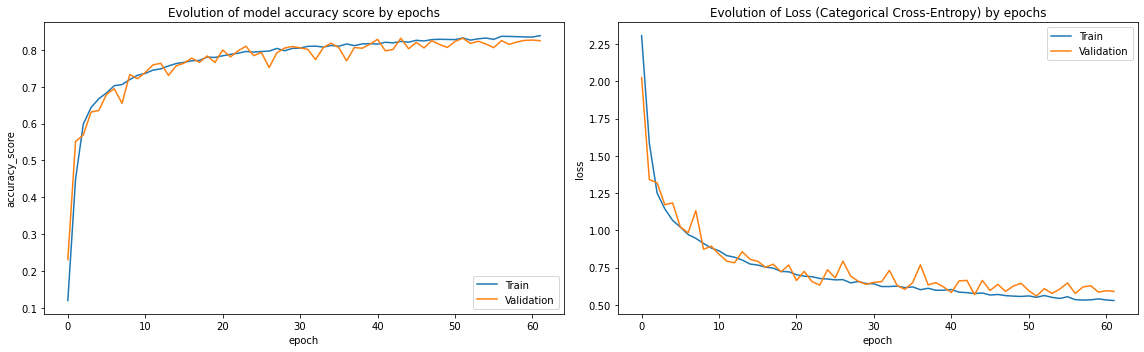

In [20]:
plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [54]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = model.evaluate(X_val, y_val_encoded)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

60000/60000 [==============================] - 8s 127us/sample - loss: 0.5596 - accuracy: 0.8317
Validation cross-entropy Loss: 0.5596312519192695
Validation classification Accuracy: 0.8317


In [55]:
# Obtain cross-entropy loss and accuracy scores on test dataset
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print('Test cross-entropy Loss:', loss)
print('Test classification Accuracy:', accuracy)

18000/18000 [==============================] - 2s 124us/sample - loss: 0.6771 - accuracy: 0.8087
Test cross-entropy Loss: 0.677125279267629
Test classification Accuracy: 0.80866665


- As noted above, with batch size of 64 and Adam optimizer with learning rate of 0.003, we get validation and test accuracies of ~83% and ~81% respectively
- After around 15 epochs the training and validation accuracy more or less stabilize and improves gradually
- There is not much of gap between training and validation curves - hence no clear evidence of overfit
- However, loss and accuracy results on validation dataset slightly more volatile vs training dataset
***
- Next I increase hidden layers to let test accuracy score improve - try to overfit first and then use regularization

In [51]:
# Initialize Neural Network (Sequential) model
model2 = tf.keras.Sequential()

# Reshape the input of 32 x 32 image into 1d array with 1024 features
model2.add(tf.keras.layers.Reshape(target_shape=(1024,), input_shape=(32,32,)))

# Add Layer 1 with 256 neurons and Leaky-ReLU activation function
model2.add(tf.keras.layers.Dense(units=256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL1'))

# Add Layer 2 with 128 neurons and Leaky-ReLU activation function
model2.add(tf.keras.layers.Dense(units=128, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL2'))

# Add Layer 3 with 64 neurons and Leaky-ReLU activation function
model2.add(tf.keras.layers.Dense(units=64, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL3'))

# Add Layer 4 with 32 neurons and Leaky-ReLU activation function
model2.add(tf.keras.layers.Dense(units=32, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL4'))

# Add Layer 5 with 32 neurons and Leaky-ReLU activation function
model2.add(tf.keras.layers.Dense(units=32, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL5'))

# Output Layer with 10 neurons and softmax activation function
model2.add(tf.keras.layers.Dense(units=10, activation='softmax', name='Output'))

In [52]:
# compile model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
# Set early stopping criteria (i.e., no improvement in validation loss in 10 successive epochs)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Train model
hist2 = model2.fit(X_train, y_train_encoded, batch_size=64, epochs=150, verbose=1,
                   validation_data=(X_val, y_val_encoded), callbacks=[callback])

Train on 42000 samples, validate on 60000 samples
Epoch 1/150
42000/42000 [==============================] - 12s 280us/sample - loss: 2.3169 - accuracy: 0.1030 - val_loss: 2.3028 - val_accuracy: 0.1074
Epoch 2/150
42000/42000 [==============================] - 11s 262us/sample - loss: 2.2869 - accuracy: 0.1175 - val_loss: 2.1588 - val_accuracy: 0.1577
Epoch 3/150
42000/42000 [==============================] - 12s 274us/sample - loss: 1.9568 - accuracy: 0.2600 - val_loss: 1.6619 - val_accuracy: 0.4114
Epoch 4/150
42000/42000 [==============================] - 11s 257us/sample - loss: 1.4563 - accuracy: 0.4965 - val_loss: 1.3427 - val_accuracy: 0.5651
Epoch 5/150
42000/42000 [==============================] - 11s 255us/sample - loss: 1.2768 - accuracy: 0.5815 - val_loss: 1.2763 - val_accuracy: 0.5903
Epoch 6/150
42000/42000 [==============================] - 11s 256us/sample - loss: 1.1592 - accuracy: 0.6313 - val_loss: 1.0430 - val_accuracy: 0.6770
Epoch 7/150
42000/42000 [=============

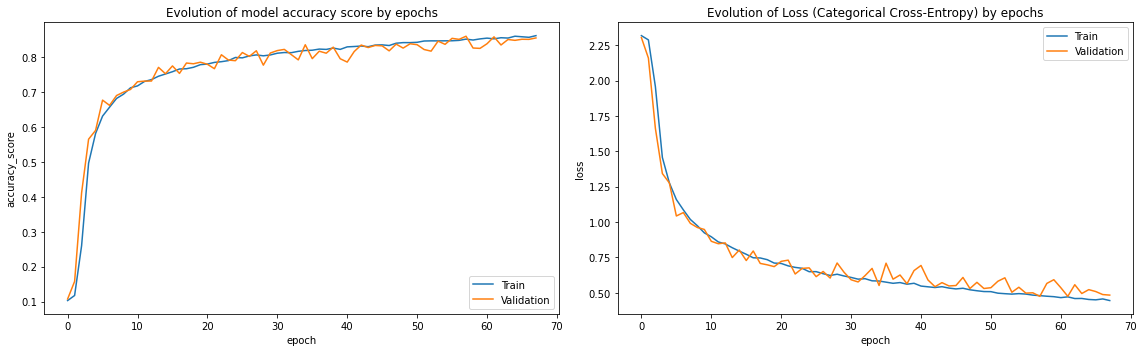

In [59]:
plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [58]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = model2.evaluate(X_val, y_val_encoded)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

60000/60000 [==============================] - 6s 94us/sample - loss: 0.4752 - accuracy: 0.8600
Validation cross-entropy Loss: 0.4752312378923098
Validation classification Accuracy: 0.86003333


In [60]:
# Obtain cross-entropy loss and accuracy scores on test dataset
loss, accuracy = model2.evaluate(X_test, y_test_encoded)
print('Test cross-entropy Loss:', loss)
print('Test classification Accuracy:', accuracy)

18000/18000 [==============================] - 2s 137us/sample - loss: 0.6142 - accuracy: 0.8303
Test cross-entropy Loss: 0.6141523158682717
Test classification Accuracy: 0.8302778


- With additional hidden layers (5 in all), the both validation accuracy (~86%) and test accuracy (~83%) improve
- There seems to have some amount of overfitting sneaking through when I compare training accuracy vs test accuracy
***
- Let's increase the hidden layers (to 7) and also increase batch size to 128
- Being SVHN data noisy, it is advisable to use smaller batch size - but given the size of training data (42000), we can increase batch size to 128 to learn better based on more training data in every epoch

In [61]:
# Initialize Neural Network (Sequential) model
model3 = tf.keras.Sequential()

# Reshape the input of 32 x 32 image into 1d array with 1024 features
model3.add(tf.keras.layers.Reshape(target_shape=(1024,), input_shape=(32,32,)))

# Add Layer 1 with 256 neurons and Leaky-ReLU activation function
model3.add(tf.keras.layers.Dense(units=256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL1'))

# Add Layer 2 with 128 neurons and Leaky-ReLU activation function
model3.add(tf.keras.layers.Dense(units=128, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL2'))

# Add Layer 3 with 64 neurons and Leaky-ReLU activation function
model3.add(tf.keras.layers.Dense(units=64, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL3'))

# Add Layer 4 with 32 neurons and Leaky-ReLU activation function
model3.add(tf.keras.layers.Dense(units=64, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL4'))

# Add Layer 5 with 32 neurons and Leaky-ReLU activation function
model3.add(tf.keras.layers.Dense(units=32, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL5'))

# Add Layer 6 with 16 neurons and Leaky-ReLU activation function
model3.add(tf.keras.layers.Dense(units=32, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL6'))

# Add Layer 7 with 32 neurons and Leaky-ReLU activation function
model3.add(tf.keras.layers.Dense(units=32, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL7'))

# Output Layer with 10 neurons and softmax activation function
model3.add(tf.keras.layers.Dense(units=10, activation='softmax', name='Output'))

In [62]:
# compile model
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
# Set early stopping criteria (i.e., no improvement in validation loss in 10 successive epochs)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Train model
hist3 = model3.fit(X_train, y_train_encoded, batch_size=128, epochs=150, verbose=1,
                   validation_data=(X_val, y_val_encoded), callbacks=[callback])

Train on 42000 samples, validate on 60000 samples
Epoch 1/150
42000/42000 [==============================] - 6s 142us/sample - loss: 2.3111 - accuracy: 0.0991 - val_loss: 2.3026 - val_accuracy: 0.1003
Epoch 2/150
42000/42000 [==============================] - 6s 147us/sample - loss: 2.3036 - accuracy: 0.0997 - val_loss: 2.3051 - val_accuracy: 0.0990
Epoch 3/150
42000/42000 [==============================] - 6s 135us/sample - loss: 2.3042 - accuracy: 0.1003 - val_loss: 2.3447 - val_accuracy: 0.0948
Epoch 4/150
42000/42000 [==============================] - 7s 157us/sample - loss: 2.3041 - accuracy: 0.1027 - val_loss: 2.3087 - val_accuracy: 0.0999
Epoch 5/150
42000/42000 [==============================] - 7s 162us/sample - loss: 2.3042 - accuracy: 0.1002 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 6/150
42000/42000 [==============================] - 6s 140us/sample - loss: 2.3034 - accuracy: 0.1000 - val_loss: 2.3029 - val_accuracy: 0.1013
Epoch 7/150
42000/42000 [===================

42000/42000 [==============================] - 7s 162us/sample - loss: 0.3857 - accuracy: 0.8807 - val_loss: 0.4196 - val_accuracy: 0.8777
Epoch 108/150
42000/42000 [==============================] - 5s 131us/sample - loss: 0.3759 - accuracy: 0.8824 - val_loss: 0.4720 - val_accuracy: 0.8595


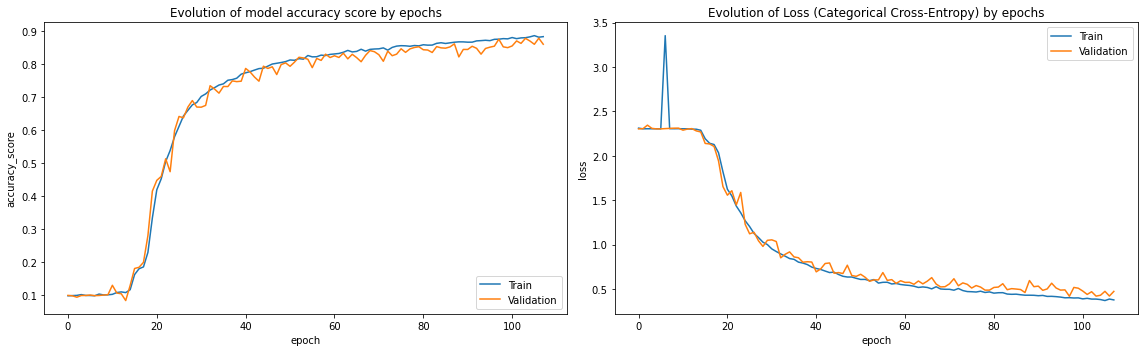

In [65]:
plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [64]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = model3.evaluate(X_val, y_val_encoded)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

60000/60000 [==============================] - 5s 81us/sample - loss: 0.4172 - accuracy: 0.8747
Validation cross-entropy Loss: 0.41715675952037173
Validation classification Accuracy: 0.87471664


In [66]:
# Obtain cross-entropy loss and accuracy scores on test dataset
loss, accuracy = model3.evaluate(X_test, y_test_encoded)
print('Test cross-entropy Loss:', loss)
print('Test classification Accuracy:', accuracy)

18000/18000 [==============================] - 1s 81us/sample - loss: 0.5787 - accuracy: 0.8354
Test cross-entropy Loss: 0.5786680428981781
Test classification Accuracy: 0.8353889


- Based on batch size of 128 and 7 hidden layers, I end up with higher validation accuracy (~87%) and test accuracy (~84).
- There seems to have certain degree of overfitting
- We can now add dropout layers after hidden layers to regularize the model and hence helpful in avoiding overfitting
- We can also add batch normalization for further regularization 

In [68]:
# Initialize Neural Network (Sequential) model
model4 = tf.keras.Sequential()

# Reshape the input of 32 x 32 image into 1d array with 1024 features
model4.add(tf.keras.layers.Reshape(target_shape=(1024,), input_shape=(32,32,)))

# Add BatchNormalization layer
model4.add(tf.keras.layers.BatchNormalization())

# Add Layer 1 with 256 neurons and Leaky-ReLU activation function
model4.add(tf.keras.layers.Dense(units=256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL1'))

# Dropout for regularization to prevent overefitting
model4.add(tf.keras.layers.Dropout(rate=0.20))

# Add Layer 2 with 128 neurons and Leaky-ReLU activation function
model4.add(tf.keras.layers.Dense(units=128, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL2'))

# Dropout for regularization to prevent overefitting
model4.add(tf.keras.layers.Dropout(rate=0.15))

# Add Layer 3 with 64 neurons and Leaky-ReLU activation function
model4.add(tf.keras.layers.Dense(units=64, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL3'))

# Dropout for regularization to prevent overefitting
model4.add(tf.keras.layers.Dropout(rate=0.05))

# Add Layer 4 with 64 neurons and Leaky-ReLU activation function
model4.add(tf.keras.layers.Dense(units=64, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL4'))

# Dropout for regularization to prevent overefitting
model4.add(tf.keras.layers.Dropout(rate=0.05))

# Add Layer 5 with 32 neurons and Leaky-ReLU activation function
model4.add(tf.keras.layers.Dense(units=32, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL5'))

# Dropout for regularization to prevent overefitting
model4.add(tf.keras.layers.Dropout(rate=0.05))

# Add Layer 6 with 32 neurons and Leaky-ReLU activation function
model4.add(tf.keras.layers.Dense(units=32, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL6'))

# Dropout for regularization to prevent overefitting
model4.add(tf.keras.layers.Dropout(rate=0.05))

# Add Layer 7 with 32 neurons and Leaky-ReLU activation function
model4.add(tf.keras.layers.Dense(units=32, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL7'))

# Dropout for regularization to prevent overefitting
model4.add(tf.keras.layers.Dropout(rate=0.05))

# Output Layer with 10 neurons and softmax activation function
model4.add(tf.keras.layers.Dense(units=10, activation='softmax', name='Output'))

In [69]:
# compile model
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
# Set early stopping criteria (i.e., no improvement in validation loss in 10 successive epochs)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Train model
hist4 = model4.fit(X_train, y_train_encoded, batch_size=128, epochs=150, verbose=1,
                   validation_data=(X_val, y_val_encoded), callbacks=[callback])

Train on 42000 samples, validate on 60000 samples
Epoch 1/150
42000/42000 [==============================] - 10s 247us/sample - loss: 1.8256 - accuracy: 0.3479 - val_loss: 1.3091 - val_accuracy: 0.5875
Epoch 2/150
42000/42000 [==============================] - 8s 201us/sample - loss: 1.2846 - accuracy: 0.5846 - val_loss: 1.0307 - val_accuracy: 0.6753
Epoch 3/150
42000/42000 [==============================] - 9s 219us/sample - loss: 1.1173 - accuracy: 0.6496 - val_loss: 0.8423 - val_accuracy: 0.7438
Epoch 4/150
42000/42000 [==============================] - 9s 218us/sample - loss: 1.0014 - accuracy: 0.6884 - val_loss: 0.7939 - val_accuracy: 0.7568
Epoch 5/150
42000/42000 [==============================] - 10s 227us/sample - loss: 0.9503 - accuracy: 0.7058 - val_loss: 0.7675 - val_accuracy: 0.7619
Epoch 6/150
42000/42000 [==============================] - 12s 295us/sample - loss: 0.9031 - accuracy: 0.7216 - val_loss: 0.6887 - val_accuracy: 0.7857
Epoch 7/150
42000/42000 [================

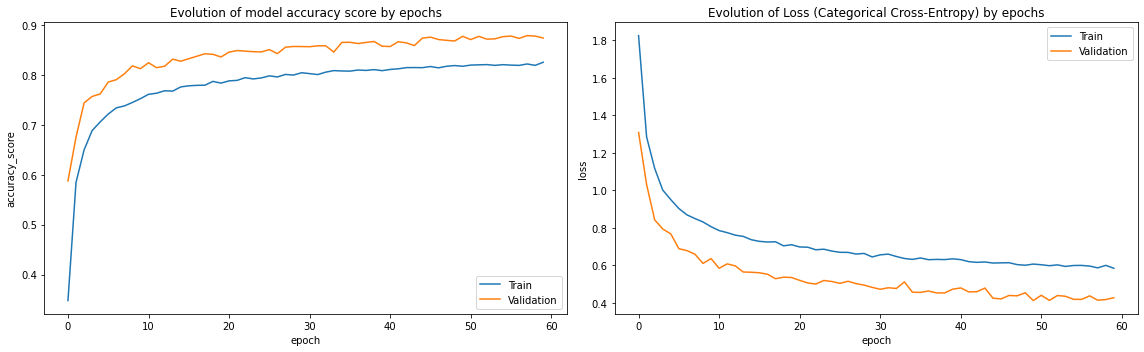

In [72]:
plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist4.history['accuracy'])
plt.plot(hist4.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [71]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = model4.evaluate(X_val, y_val_encoded)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

60000/60000 [==============================] - 9s 156us/sample - loss: 0.4117 - accuracy: 0.8773
Validation cross-entropy Loss: 0.41174268075923126
Validation classification Accuracy: 0.87731665


In [73]:
# Obtain cross-entropy loss and accuracy scores on test dataset
loss, accuracy = model4.evaluate(X_test, y_test_encoded)
print('Test cross-entropy Loss:', loss)
print('Test classification Accuracy:', accuracy)

18000/18000 [==============================] - 2s 89us/sample - loss: 0.4908 - accuracy: 0.8554
Test cross-entropy Loss: 0.49082696090804206
Test classification Accuracy: 0.85544443


- Adding dropout rates after every hidden layer does improve accuracy for both validation and test datasets (accuracies ~88% and ~86% respectively)
- Notably, validation accuracy (loss) is consistently higher (lower) vs training accuracy (loss). This is somewhat counterintuitive - even if we compare the results for the cases without any dropout layers
- However, since we are using dropout layer after every hidden layer, we are disabling number of neurons past every hidden layer => fraction of info about each sample/feature is lost, and the subsequent layers attempt to construct predictions using "incomplete" representations. Thus we are making it artificially harder for the network to give right answers. Hence lower training accuracy.
- On the contrary, during validation no dropout layers are considered and all of the units are available for prediction. Thus the network has "complete" info to predict class membership => higher validation accuracy
- Next I include batch normalization after every layer to check if validation and test accuracy improve further

In [74]:
# Initialize Neural Network (Sequential) model
model5 = tf.keras.Sequential()

# Reshape the input of 32 x 32 image into 1d array with 1024 features
model5.add(tf.keras.layers.Reshape(target_shape=(1024,), input_shape=(32,32,)))

# Add BatchNormalization layer
model5.add(tf.keras.layers.BatchNormalization())

# Add Layer 1 with 256 neurons and Leaky-ReLU activation function
model5.add(tf.keras.layers.Dense(units=256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL1'))

# Add BatchNormalization layer
model5.add(tf.keras.layers.BatchNormalization())

# Dropout for regularization to prevent overefitting
model5.add(tf.keras.layers.Dropout(rate=0.20))

# Add Layer 2 with 128 neurons and Leaky-ReLU activation function
model5.add(tf.keras.layers.Dense(units=128, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL2'))

# Add BatchNormalization layer
model5.add(tf.keras.layers.BatchNormalization())

# Dropout for regularization to prevent overefitting
model5.add(tf.keras.layers.Dropout(rate=0.15))

# Add Layer 3 with 64 neurons and Leaky-ReLU activation function
model5.add(tf.keras.layers.Dense(units=64, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL3'))

# Add BatchNormalization layer
model5.add(tf.keras.layers.BatchNormalization())

# Dropout for regularization to prevent overefitting
model5.add(tf.keras.layers.Dropout(rate=0.05))

# Add Layer 4 with 64 neurons and Leaky-ReLU activation function
model5.add(tf.keras.layers.Dense(units=64, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL4'))

# Add BatchNormalization layer
model5.add(tf.keras.layers.BatchNormalization())

# Dropout for regularization to prevent overefitting
model5.add(tf.keras.layers.Dropout(rate=0.05))

# Add Layer 5 with 32 neurons and Leaky-ReLU activation function
model5.add(tf.keras.layers.Dense(units=32, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL5'))

# Add BatchNormalization layer
model5.add(tf.keras.layers.BatchNormalization())

# Dropout for regularization to prevent overefitting
model5.add(tf.keras.layers.Dropout(rate=0.05))

# Add Layer 6 with 32 neurons and Leaky-ReLU activation function
model5.add(tf.keras.layers.Dense(units=32, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL6'))

# Add BatchNormalization layer
model5.add(tf.keras.layers.BatchNormalization())

# Dropout for regularization to prevent overefitting
model5.add(tf.keras.layers.Dropout(rate=0.05))

# Add Layer 7 with 32 neurons and Leaky-ReLU activation function
model5.add(tf.keras.layers.Dense(units=32, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL7'))

# Add BatchNormalization layer
model5.add(tf.keras.layers.BatchNormalization())

# Dropout for regularization to prevent overefitting
model5.add(tf.keras.layers.Dropout(rate=0.05))

# Output Layer with 10 neurons and softmax activation function
model5.add(tf.keras.layers.Dense(units=10, activation='softmax', name='Output'))

In [75]:
# compile model
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
# Set early stopping criteria (i.e., no improvement in validation loss in 10 successive epochs)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Train model
hist5 = model5.fit(X_train, y_train_encoded, batch_size=128, epochs=150, verbose=1,
                   validation_data=(X_val, y_val_encoded), callbacks=[callback])

Train on 42000 samples, validate on 60000 samples
Epoch 1/150
42000/42000 [==============================] - 15s 346us/sample - loss: 1.7683 - accuracy: 0.3695 - val_loss: 1.3014 - val_accuracy: 0.5585 
Epoch 2/150
42000/42000 [==============================] - 14s 322us/sample - loss: 1.3202 - accuracy: 0.5675 - val_loss: 1.0245 - val_accuracy: 0.6765
Epoch 3/150
42000/42000 [==============================] - 13s 313us/sample - loss: 1.1607 - accuracy: 0.6308 - val_loss: 0.9314 - val_accuracy: 0.7077
Epoch 4/150
42000/42000 [==============================] - 12s 294us/sample - loss: 1.0681 - accuracy: 0.6640 - val_loss: 0.8742 - val_accuracy: 0.7253
Epoch 5/150
42000/42000 [==============================] - 14s 323us/sample - loss: 0.9904 - accuracy: 0.6915 - val_loss: 0.7819 - val_accuracy: 0.7574
Epoch 6/150
42000/42000 [==============================] - 12s 288us/sample - loss: 0.9415 - accuracy: 0.7068 - val_loss: 0.7565 - val_accuracy: 0.7661
Epoch 7/150
42000/42000 [============

42000/42000 [==============================] - 14s 325us/sample - loss: 0.5033 - accuracy: 0.8419 - val_loss: 0.3393 - val_accuracy: 0.8969
Epoch 107/150
42000/42000 [==============================] - 13s 309us/sample - loss: 0.5053 - accuracy: 0.8428 - val_loss: 0.3446 - val_accuracy: 0.8958
Epoch 108/150
42000/42000 [==============================] - 13s 301us/sample - loss: 0.5022 - accuracy: 0.8434 - val_loss: 0.3630 - val_accuracy: 0.8884
Epoch 109/150
42000/42000 [==============================] - 13s 312us/sample - loss: 0.4995 - accuracy: 0.8420 - val_loss: 0.3305 - val_accuracy: 0.9009
Epoch 110/150
42000/42000 [==============================] - 13s 318us/sample - loss: 0.5016 - accuracy: 0.8427 - val_loss: 0.3420 - val_accuracy: 0.8957
Epoch 111/150
42000/42000 [==============================] - 13s 306us/sample - loss: 0.4948 - accuracy: 0.8460 - val_loss: 0.3402 - val_accuracy: 0.8958
Epoch 112/150
42000/42000 [==============================] - 12s 276us/sample - loss: 0.49

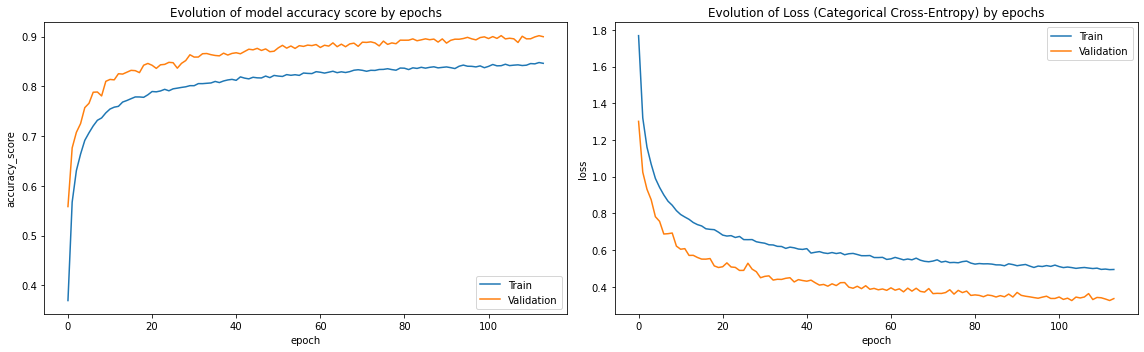

In [78]:
plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist5.history['accuracy'])
plt.plot(hist5.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist5.history['loss'])
plt.plot(hist5.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [77]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = model5.evaluate(X_val, y_val_encoded)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

60000/60000 [==============================] - 10s 159us/sample - loss: 0.3251 - accuracy: 0.9021
Validation cross-entropy Loss: 0.3250739485060175
Validation classification Accuracy: 0.90211666


In [79]:
# Obtain cross-entropy loss and accuracy scores on test dataset
loss, accuracy = model5.evaluate(X_test, y_test_encoded)
print('Test cross-entropy Loss:', loss)
print('Test classification Accuracy:', accuracy)

18000/18000 [==============================] - 3s 187us/sample - loss: 0.4174 - accuracy: 0.8737
Test cross-entropy Loss: 0.41739741219414606
Test classification Accuracy: 0.87366664


- The above results presented clearly has the best validation and test accuracy scores as yet
- Validation accuracy and Test accuracy are 90%+ and 87%+ respectively
- As noted in the earlier iteration too, validation accuracy (loss) is consistently higher (lower) vs training accuracy (loss) here attributed mainly due to dropout layer invoked after every hidden layer
***
- Now that we already have regularization parameters, let's consider a simpler model from parsimonious point of view
- So I keep first three hidden layers, fine-tune the learning rate (to 0.0025) for Adam optimizer and increase epochs to 200 further keeping an early stopping rule of no improvement in validation loss in 10 successive epochs

In [93]:
# Initialize Neural Network (Sequential) model
model6 = tf.keras.Sequential()

# Reshape the input of 32 x 32 image into 1d array with 1024 features
model6.add(tf.keras.layers.Reshape(target_shape=(1024,), input_shape=(32,32,)))

# Add BatchNormalization layer
model6.add(tf.keras.layers.BatchNormalization())

# Add Layer 1 with 256 neurons and Leaky-ReLU activation function
model6.add(tf.keras.layers.Dense(units=256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                 activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL1'))

# Add BatchNormalization layer
model6.add(tf.keras.layers.BatchNormalization())

# Dropout for regularization to prevent overefitting
model6.add(tf.keras.layers.Dropout(rate=0.20))

# Add Layer 2 with 128 neurons and Leaky-ReLU activation function
model6.add(tf.keras.layers.Dense(units=128, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                 activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL2'))

# Add BatchNormalization layer
model6.add(tf.keras.layers.BatchNormalization())

# Dropout for regularization to prevent overefitting
model6.add(tf.keras.layers.Dropout(rate=0.10))

# Add Layer 3 with 64 neurons and Leaky-ReLU activation function
model6.add(tf.keras.layers.Dense(units=64, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7),
                                 activation=tf.keras.layers.LeakyReLU(alpha=0.3), name='HL3'))

# Add BatchNormalization layer
model6.add(tf.keras.layers.BatchNormalization())

# Dropout for regularization to prevent overefitting
model6.add(tf.keras.layers.Dropout(rate=0.05))

# Output Layer with 10 neurons and softmax activation function
model6.add(tf.keras.layers.Dense(units=10, activation='softmax', name='Output'))

In [94]:
# compile model
model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025), loss='categorical_crossentropy', metrics=['accuracy'])

In [95]:
# Set early stopping criteria (i.e., no improvement in validation loss in 10 successive epochs)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Train model
hist6 = model6.fit(X_train, y_train_encoded, batch_size=128, epochs=200, verbose=1,
                   validation_data=(X_val, y_val_encoded), callbacks=[callback])

Train on 42000 samples, validate on 60000 samples
Epoch 1/200
42000/42000 [==============================] - 9s 205us/sample - loss: 1.5450 - accuracy: 0.4907 - val_loss: 1.0922 - val_accuracy: 0.6696
Epoch 2/200
42000/42000 [==============================] - 8s 186us/sample - loss: 1.0943 - accuracy: 0.6555 - val_loss: 0.8827 - val_accuracy: 0.7263
Epoch 3/200
42000/42000 [==============================] - 8s 200us/sample - loss: 0.9690 - accuracy: 0.6977 - val_loss: 0.7714 - val_accuracy: 0.7648
Epoch 4/200
42000/42000 [==============================] - 8s 195us/sample - loss: 0.8862 - accuracy: 0.7229 - val_loss: 0.6977 - val_accuracy: 0.7872
Epoch 5/200
42000/42000 [==============================] - 9s 215us/sample - loss: 0.8278 - accuracy: 0.7435 - val_loss: 0.6435 - val_accuracy: 0.8085
Epoch 6/200
42000/42000 [==============================] - 9s 219us/sample - loss: 0.7911 - accuracy: 0.7562 - val_loss: 0.6091 - val_accuracy: 0.8191
Epoch 7/200
42000/42000 [===================

42000/42000 [==============================] - 9s 220us/sample - loss: 0.4463 - accuracy: 0.8575 - val_loss: 0.3109 - val_accuracy: 0.9102
Epoch 108/200
42000/42000 [==============================] - 9s 217us/sample - loss: 0.4495 - accuracy: 0.8573 - val_loss: 0.3240 - val_accuracy: 0.9033
Epoch 109/200
42000/42000 [==============================] - 8s 197us/sample - loss: 0.4444 - accuracy: 0.8599 - val_loss: 0.3248 - val_accuracy: 0.9049
Epoch 110/200
42000/42000 [==============================] - 9s 207us/sample - loss: 0.4477 - accuracy: 0.8599 - val_loss: 0.3060 - val_accuracy: 0.9119
Epoch 111/200
42000/42000 [==============================] - 9s 210us/sample - loss: 0.4461 - accuracy: 0.8582 - val_loss: 0.3137 - val_accuracy: 0.9095
Epoch 112/200
42000/42000 [==============================] - 9s 203us/sample - loss: 0.4479 - accuracy: 0.8590 - val_loss: 0.3164 - val_accuracy: 0.9066
Epoch 113/200
42000/42000 [==============================] - 9s 220us/sample - loss: 0.4455 - ac

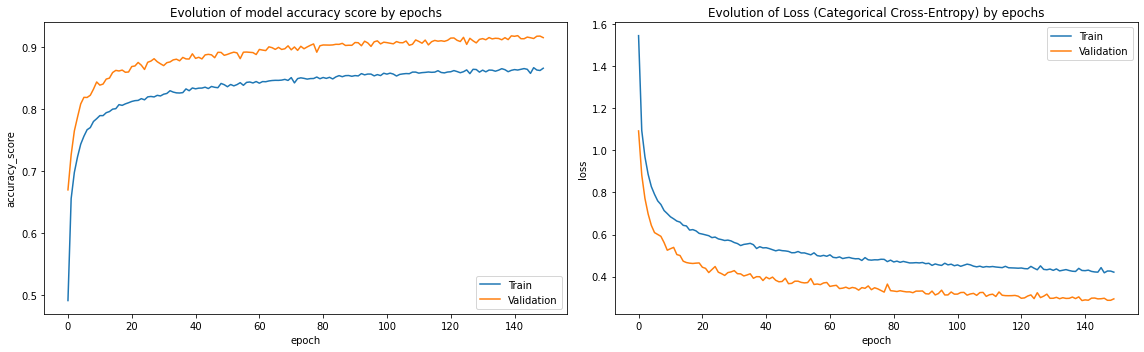

In [100]:
plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist6.history['accuracy'])
plt.plot(hist6.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist6.history['loss'])
plt.plot(hist6.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [101]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = model6.evaluate(X_val, y_val_encoded)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

60000/60000 [==============================] - 10s 162us/sample - loss: 0.2861 - accuracy: 0.9185
Validation cross-entropy Loss: 0.286096117315193
Validation classification Accuracy: 0.9184833


In [102]:
# Obtain cross-entropy loss and accuracy scores on test dataset
loss, accuracy = model6.evaluate(X_test, y_test_encoded)
print('Test cross-entropy Loss:', loss)
print('Test classification Accuracy:', accuracy)

18000/18000 [==============================] - 3s 169us/sample - loss: 0.4200 - accuracy: 0.8808
Test cross-entropy Loss: 0.41998647295766406
Test classification Accuracy: 0.8808333


- With only three hidden layers, dropout layers and batch-normalization applied after each hidden layer applied, validation accuracy and test accuracy are ~92% and 88%+ respectively - the best accuracy obtained so far
- Again as before, we have consistent outperformance of classifier on validation data vs on training data, attributed due to dropout effect
- Notably, validation accuracy is very much stable - i.e., lower the variance in accuracy and hence higher the confidence in validation accuracy to remain
- The same is reflected through a descent test accuracy of 88%
***
- Let's play around with optimization algo - try Nadam

In [103]:
def create_model(numLayers=3, 
                 numNeurons=[256,128,64], 
                 activation_fn=[tf.keras.layers.LeakyReLU(alpha=0.3)]*3,
                 kernel_initializer=[tf.keras.initializers.glorot_uniform(seed=7)]*3,
                 dropout_rate=[0.20, 0.10, 0.05], 
                 output_activation_fn='softmax',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025)):
    
    # Initialize sequential Network
    model = tf.keras.Sequential()
    
    # Reshape the input of 32 x 32 image into 1d array with 1024 features
    model.add(tf.keras.layers.Reshape(target_shape=(1024,), input_shape=(32,32,)))
    
    # Add batch normalization
    model.add(tf.keras.layers.BatchNormalization())
        
    if (numLayers==len(numNeurons)) & (numLayers==len(activation_fn)) & (numLayers==len(kernel_initializer)) \
            & (numLayers==len(dropout_rate)):
        
        # Build hidden layers
        for l in range(numLayers):
            # Add network layers
            model.add(tf.keras.layers.Dense(units=numNeurons[l], activation=activation_fn[l],
                                            kernel_initializer=kernel_initializer[l]))
            
            # Add batch normalization
            model.add(tf.keras.layers.BatchNormalization())
            
            # Add dropout rates for regularization + avoid overfitting
            model.add(tf.keras.layers.Dropout(rate=dropout_rate[l]))
    
    # Output Layer with 10 neurons and softmax activation function
    model.add(tf.keras.layers.Dense(units=10, activation=output_activation_fn))
    
    # Compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return(model)

In [104]:
# Build NN model and fit on training dataset
model7 = create_model(numLayers=3, 
                      numNeurons=[256,128,64], 
                      activation_fn=[tf.keras.layers.LeakyReLU(alpha=0.3)]*3,
                      kernel_initializer=[tf.keras.initializers.glorot_uniform(seed=7)]*3,
                      dropout_rate=[0.20, 0.10, 0.05], 
                      output_activation_fn='softmax',
                      optimizer=tf.keras.optimizers.Nadam())

# Set early stopping criteria (i.e., no improvement in validation loss in 10 successive epochs)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Train model
hist7 = model7.fit(X_train, y_train_encoded, batch_size=128, epochs=200, verbose=1,
                   validation_data=(X_val, y_val_encoded), callbacks=[callback])

Train on 42000 samples, validate on 60000 samples
Epoch 1/200
42000/42000 [==============================] - 12s 292us/sample - loss: 1.5369 - accuracy: 0.4983 - val_loss: 1.2494 - val_accuracy: 0.6018
Epoch 2/200
42000/42000 [==============================] - 9s 225us/sample - loss: 1.0684 - accuracy: 0.6632 - val_loss: 0.9727 - val_accuracy: 0.6973
Epoch 3/200
42000/42000 [==============================] - 10s 249us/sample - loss: 0.9585 - accuracy: 0.7022 - val_loss: 1.5667 - val_accuracy: 0.5870
Epoch 4/200
42000/42000 [==============================] - 10s 233us/sample - loss: 0.8950 - accuracy: 0.7231 - val_loss: 0.8028 - val_accuracy: 0.7523
Epoch 5/200
42000/42000 [==============================] - 10s 243us/sample - loss: 0.8284 - accuracy: 0.7430 - val_loss: 0.9430 - val_accuracy: 0.7167
Epoch 6/200
42000/42000 [==============================] - 10s 243us/sample - loss: 0.7952 - accuracy: 0.7553 - val_loss: 0.6372 - val_accuracy: 0.8072
Epoch 7/200
42000/42000 [==============

42000/42000 [==============================] - 11s 259us/sample - loss: 0.4973 - accuracy: 0.8443 - val_loss: 0.3765 - val_accuracy: 0.8892
Epoch 55/200
42000/42000 [==============================] - 10s 233us/sample - loss: 0.5031 - accuracy: 0.8432 - val_loss: 0.3540 - val_accuracy: 0.8981
Epoch 56/200
42000/42000 [==============================] - 9s 218us/sample - loss: 0.4974 - accuracy: 0.8453 - val_loss: 0.3890 - val_accuracy: 0.8857
Epoch 57/200
42000/42000 [==============================] - 10s 246us/sample - loss: 0.4908 - accuracy: 0.8476 - val_loss: 0.3579 - val_accuracy: 0.8967
Epoch 58/200
42000/42000 [==============================] - 10s 241us/sample - loss: 0.4987 - accuracy: 0.8441 - val_loss: 0.3544 - val_accuracy: 0.8966
Epoch 59/200
42000/42000 [==============================] - 10s 232us/sample - loss: 0.4893 - accuracy: 0.8471 - val_loss: 0.3811 - val_accuracy: 0.8870
Epoch 60/200
42000/42000 [==============================] - 10s 235us/sample - loss: 0.4939 - ac

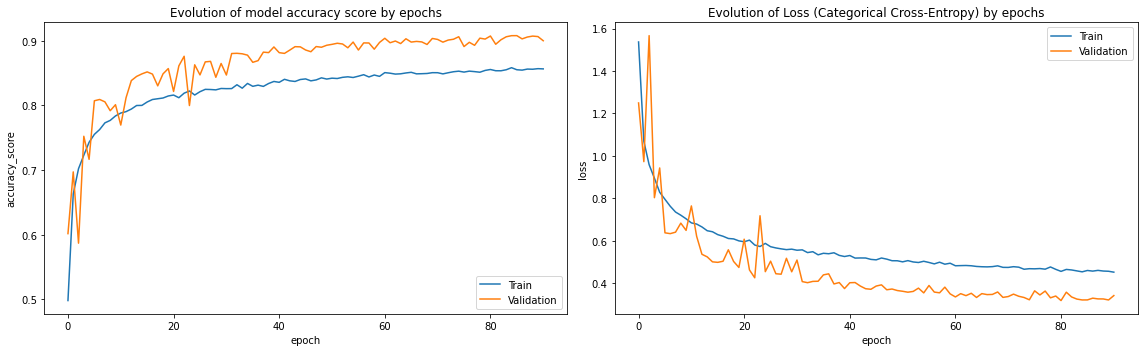

In [105]:
plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist7.history['accuracy'])
plt.plot(hist7.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist7.history['loss'])
plt.plot(hist7.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [106]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = model7.evaluate(X_val, y_val_encoded)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

60000/60000 [==============================] - 9s 145us/sample - loss: 0.3179 - accuracy: 0.9074
Validation cross-entropy Loss: 0.3178959716240565
Validation classification Accuracy: 0.9074


In [107]:
# Obtain cross-entropy loss and accuracy scores on test dataset
loss, accuracy = model7.evaluate(X_test, y_test_encoded)
print('Test cross-entropy Loss:', loss)
print('Test classification Accuracy:', accuracy)

18000/18000 [==============================] - 3s 150us/sample - loss: 0.4334 - accuracy: 0.8743
Test cross-entropy Loss: 0.43340830244620643
Test classification Accuracy: 0.8743333


- Validation and Test accuracy scores are ~91% and 87%+ respectively
- Adam optimizer still does touch better vs Nadam
***
- Since images have noise, we may also want to consider SGD with Nesterov momentum

In [108]:
# Build NN model and fit on training dataset
model8 = create_model(numLayers=3, 
                      numNeurons=[256,128,64], 
                      activation_fn=[tf.keras.layers.LeakyReLU(alpha=0.3)]*3,
                      kernel_initializer=[tf.keras.initializers.glorot_uniform(seed=7)]*3,
                      dropout_rate=[0.20, 0.10, 0.05], 
                      output_activation_fn='softmax',
                      optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, nesterov=True))

# Set early stopping criteria (i.e., no improvement in validation loss in 10 successive epochs)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Train model
hist8 = model8.fit(X_train, y_train_encoded, batch_size=128, epochs=200, verbose=1,
                   validation_data=(X_val, y_val_encoded), callbacks=[callback])

Train on 42000 samples, validate on 60000 samples
Epoch 1/200
42000/42000 [==============================] - 11s 259us/sample - loss: 1.8181 - accuracy: 0.3845 - val_loss: 1.3329 - val_accuracy: 0.6218
Epoch 2/200
42000/42000 [==============================] - 8s 195us/sample - loss: 1.2352 - accuracy: 0.6082 - val_loss: 1.0154 - val_accuracy: 0.6964
Epoch 3/200
42000/42000 [==============================] - 10s 243us/sample - loss: 1.0753 - accuracy: 0.6618 - val_loss: 0.8357 - val_accuracy: 0.7521
Epoch 4/200
42000/42000 [==============================] - 10s 244us/sample - loss: 0.9799 - accuracy: 0.6917 - val_loss: 0.7796 - val_accuracy: 0.7695
Epoch 5/200
42000/42000 [==============================] - 9s 208us/sample - loss: 0.9241 - accuracy: 0.7118 - val_loss: 0.7274 - val_accuracy: 0.7806
Epoch 6/200
42000/42000 [==============================] - 12s 278us/sample - loss: 0.8793 - accuracy: 0.7281 - val_loss: 0.6808 - val_accuracy: 0.7965
Epoch 7/200
42000/42000 [===============

42000/42000 [==============================] - 12s 285us/sample - loss: 0.5360 - accuracy: 0.8332 - val_loss: 0.4284 - val_accuracy: 0.8740
Epoch 55/200
42000/42000 [==============================] - 9s 219us/sample - loss: 0.5402 - accuracy: 0.8304 - val_loss: 0.3753 - val_accuracy: 0.8921
Epoch 56/200
42000/42000 [==============================] - 11s 264us/sample - loss: 0.5293 - accuracy: 0.8343 - val_loss: 0.3787 - val_accuracy: 0.8913
Epoch 57/200
42000/42000 [==============================] - 11s 253us/sample - loss: 0.5235 - accuracy: 0.8362 - val_loss: 0.3780 - val_accuracy: 0.8910
Epoch 58/200
42000/42000 [==============================] - 10s 249us/sample - loss: 0.5306 - accuracy: 0.8324 - val_loss: 0.3762 - val_accuracy: 0.89245317 - accuracy
Epoch 59/200
42000/42000 [==============================] - 10s 247us/sample - loss: 0.5229 - accuracy: 0.8337 - val_loss: 0.3727 - val_accuracy: 0.8926
Epoch 60/200
42000/42000 [==============================] - 11s 256us/sample - lo

Epoch 108/200
42000/42000 [==============================] - 3s 80us/sample - loss: 0.4590 - accuracy: 0.8545 - val_loss: 0.3133 - val_accuracy: 0.9117
Epoch 109/200
42000/42000 [==============================] - 3s 82us/sample - loss: 0.4618 - accuracy: 0.8543 - val_loss: 0.3253 - val_accuracy: 0.9064
Epoch 110/200
42000/42000 [==============================] - 3s 81us/sample - loss: 0.4536 - accuracy: 0.8558 - val_loss: 0.3188 - val_accuracy: 0.9090
Epoch 111/200
42000/42000 [==============================] - 3s 82us/sample - loss: 0.4532 - accuracy: 0.8553 - val_loss: 0.3193 - val_accuracy: 0.9091
Epoch 112/200
42000/42000 [==============================] - 3s 82us/sample - loss: 0.4542 - accuracy: 0.8581 - val_loss: 0.3100 - val_accuracy: 0.9127
Epoch 113/200
42000/42000 [==============================] - 4s 90us/sample - loss: 0.4562 - accuracy: 0.8559 - val_loss: 0.3186 - val_accuracy: 0.9089
Epoch 114/200
42000/42000 [==============================] - 4s 88us/sample - loss: 0.45

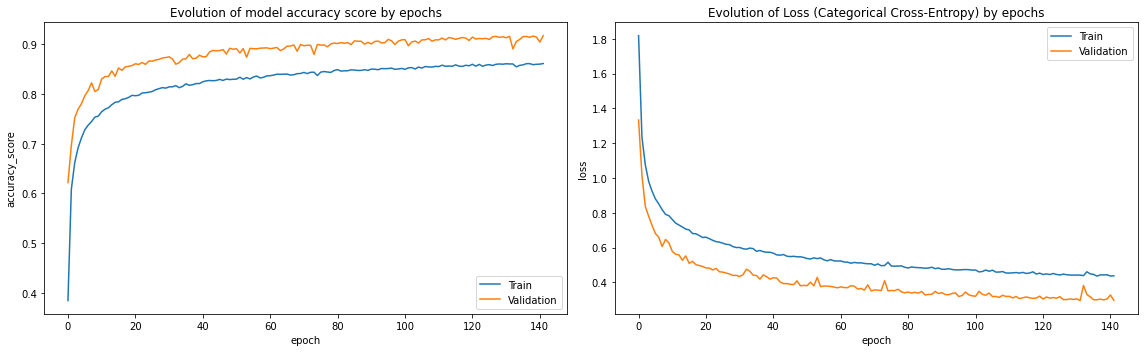

In [109]:
plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist8.history['accuracy'])
plt.plot(hist8.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist8.history['loss'])
plt.plot(hist8.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [110]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = model8.evaluate(X_val, y_val_encoded)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

60000/60000 [==============================] - 2s 41us/sample - loss: 0.2951 - accuracy: 0.9161s - loss: 0.3218 -  - ETA: 1s - loss: 0.3348 -  - ETA: 0s - loss: 0.3404 - accuracy: 0. - ETA: 0s - los
Validation cross-entropy Loss: 0.29508695863236983
Validation classification Accuracy: 0.91606665


In [111]:
# Obtain cross-entropy loss and accuracy scores on test dataset
loss, accuracy = model8.evaluate(X_test, y_test_encoded)
print('Test cross-entropy Loss:', loss)
print('Test classification Accuracy:', accuracy)

18000/18000 [==============================] - 1s 41us/sample - loss: 0.4359 - accuracy: 0.8751s - loss: 0.4290 - accuracy
Test cross-entropy Loss: 0.43594426162375344
Test classification Accuracy: 0.87505555


- Again we have fairly good accuracy in both validation and test datasets for SGD with Nesterov momentum
- Validation accuracy ~92% and Test accuracy of ~87.5%
- However, Adam still beats SGD optimizer in terms of both min loss and max accuracy
- I tried RMSProp too and found Adam to be the best still
***
- I finalize the best model having validation accuracy of 91.85% (loss: 28.61%), and test accuracy of 88.08% (loss: 41.99%)
- *Model specification*: Neural Net with three hidden layers, with batch normalization and dropout layers applied after each hidden layer, hidden layer activation function as Leaky ReLU with alpha = 0.3, optimizer being Adam with learning rate 0.0025, model evaluated using softmax activation function in the output layer along with categorical cross-entropy as loss function

#### Model evaluation

In [112]:
# Store the best model
best_model = model6

In [119]:
# Prepare target data for model evaluation
y_test_actual = np.argmax(y_test_encoded, axis=1)
y_test_pred = np.argmax(best_model.predict(X_test), axis=1)

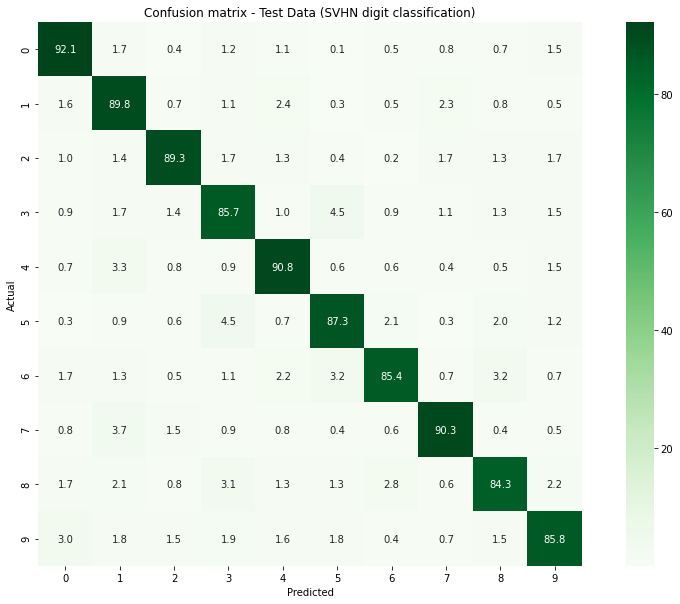

In [134]:
# Set the figure size
plt.figure(figsize=(16, 10))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=y_test_actual, y_pred=y_test_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Greens', fmt='.1f', square=True)\
.set_title('Confusion matrix - Test Data (SVHN digit classification)')
_ = plt.xlabel('Predicted')
_ = plt.ylabel('Actual')

#### Comments on confusion matrix above:
- Digits 0, 4 and 7 are classified most accurately (92.1%, 90.8% and 90.3% respectively)
- Digits 8, 6, 3 and 9 are classified not so accurately - this is clearly evident from the fact that digits 8, 6, 3 and 9 have very similar turns and edges
- Digit prediction accuracy scores for SVHN using DNN range from 84.3% to 92.1%

In [133]:
# Print the classification report
print(classification_report(y_test_actual, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1814
           1       0.84      0.90      0.87      1828
           2       0.92      0.89      0.90      1803
           3       0.83      0.86      0.84      1719
           4       0.88      0.91      0.89      1812
           5       0.87      0.87      0.87      1768
           6       0.91      0.85      0.88      1832
           7       0.91      0.90      0.91      1808
           8       0.88      0.84      0.86      1812
           9       0.89      0.86      0.87      1804

    accuracy                           0.88     18000
   macro avg       0.88      0.88      0.88     18000
weighted avg       0.88      0.88      0.88     18000



- Looking at the f1-scores, digits 7, 0 and 2 are classified most accurately

### Conclusion:
- ANN / DNN predicts image classification based on distribution of image pixel intensities
- The dataset in hand is of SVHN image - and, hence the images contain lots of noise and is hard to discern simply by looking at the pixel intensities
- The best ANN model has validation accuracy score of ~92%; while the same model achieved test accuracy score of 88%
- Whatever the best DNN model you apply, in case the source image contains lot of blurriness / noise, you can't get very high accuracy unless you have technology to detect the edges of the images.
- I think CNN is a better candidate technology for SVHN image classification problem given its inherent complexity.

In [235]:
# Prepare model and fitting parameters ... [for future tests in Grid Search CV for Neural Nets]
#mdl = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model
#                                                     , verbose=0
#                                                     , validation_data=(X_val, y_val_encoded)
#                                                     , callbacks=[callback]
#                                                    )

# **********************************************************
#batch_size=[64, 128] 
#epochs=[100,150,200]

#activation_fn=[[tf.keras.layers.LeakyReLU(alpha=0.3)]*3, ['relu']*3, ['tanh']*3, ['sigmoid']*3]
#optimizer = [tf.keras.optimizers.Adam(learning_rate=0.0025), 
#             tf.keras.optimizers.Nadam(learning_rate=0.0025),
#             tf.keras.optimizers.RMSprop(learning_rate=0.0025),
#             tf.keras.optimizers.SGD(learning_rate=0.0025, nesterov=True)] #'Adagrad', 'Adadelta', 'Adamax'

#param_grid = dict(batch_size=batch_size, epochs=epochs, activation_fn=activation_fn, optimizer=optimizer)

#from sklearn.model_selection import GridSearchCV
#grid = GridSearchCV(estimator=mdl, param_grid=param_grid, n_jobs=-1, cv=3)
#grid_result = grid.fit(X_train, y_train_encoded)

# ***********************************************************
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

## <center><font color='green'>*******End of Project Solution*******</font></center>